In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import GPy
#from dgp_sampler import DGP_sampler


from context import dgpr
from context import gpr
from context import ei
from context import lbfgs_search
from context import base_task
from context import metrics
from context import aep
import testing
import time
import sys
import os
import pdb

# import matplotlib as mpl
# if os.environ.get('DISPLAY','') == '':
# 	print('no display found. Using non-interactive Agg backend')
# 	mpl.use('Agg')
import matplotlib.pyplot as plt

np.random.seed(44)

def load_data(data_idx, N_train):
	path = 'exp_DGP_samples/data/DGP[1]_'
	DGP_data_file_train = path + str(data_idx) + '_train.txt'
	DGP_data_file_test = path + str(data_idx) + '_test.txt'
	# LOAD dgp sampled training and testing data separatery generated from REG_DGP_sampling notebook 
	X,y = np.loadtxt(DGP_data_file_train, delimiter=',', unpack=True)
	N = X.shape[0] # 3000
	list_indx = np.random.choice(range(N), N_train)
	X_train = X[list_indx,None]
	y_train = y[list_indx,None]
	X_test, y_test = np.loadtxt(DGP_data_file_test, delimiter=',', unpack=True)

	return X_train, y_train, X_test, y_test

data_idx = 3
# exp_name = 'DGP_'+str(data_idx)
exp_name = 'meeting'
# main_folder = 'thesis_work/exp_/DGP_'+str(data_idx)+'/'
main_folder = 'exp_init/'
os.system('mkdir ' + main_folder )
main_folder = 'exp_init/meeting'
# DGP_'+str(data_idx)+'/'
os.system('mkdir ' + main_folder )
#QUICK TESTING 

/Users/sergiopascualdiaz/mlsalt-code/geepee/geepee/
/Users/sergiopascualdiaz/mlsalt-code/thesis_work


256

In [2]:
N_train = 1000
M=50
hidden_size=[2]
print "load dataset ..." , (data_idx, N_train)
X_train, y_train, X_test, y_test = load_data(data_idx, N_train)

optimizer='adam'
# max_it=2000
max_it=2000
mini_batch = N_train/2
l_rate = 0.01

df = testing.start_df(['DGP'], N_train)
df['hidden_size'], df['M'] = str(hidden_size), M
t0 = time.clock()

load dataset ... (3, 1000)


In [3]:
model = aep.SDGPR(X_train, y_train, M, hidden_size, lik='Gaussian')

if optimizer=='adam':
    # model.set_fixed_params(['sn'])
    # df['config'] = 'fix_sn'
    # model.set_fixed_params(['zu_0','zu_1'])
    # df['config'] = 'fix_zu_0'
    model.optimise(method='adam', adam_lr=l_rate, mb_size=mini_batch, maxiter=max_it, disp=True)
    df['optimizer'] = optimizer + '_lr' + str(l_rate) + '_MB' + str(mini_batch) + '_Mxit' + str(max_it)
else: 
    model.optimise(method='L-BFGS-B', maxiter=max_it, disp=False)
    df['optimizer'] = optimizer + '_Mxit' + str(max_it)
SN = np.exp(model.get_hypers()['sn'])
print 'sn: ' , SN

 /Users/sergiopascualdiaz/miniconda2/lib/python2.7/site-packages/scipy/cluster/vq.py:660: UserWarning:One of the clusters is empty. Re-run kmean with a different initialization.


iter 0 	 obj 21.153
iter 50 	 obj 4.635
iter 100 	 obj 3.826
iter 150 	 obj 3.075
iter 200 	 obj 2.498
iter 250 	 obj 1.863
iter 300 	 obj 1.336
iter 350 	 obj 1.059
iter 400 	 obj 0.983
iter 450 	 obj 0.983
iter 500 	 obj 0.990
iter 550 	 obj 0.958
iter 600 	 obj 0.906
iter 650 	 obj 0.911
iter 700 	 obj 0.897
iter 750 	 obj 0.851
iter 800 	 obj 0.887
iter 850 	 obj 0.852
iter 900 	 obj 0.817
iter 950 	 obj 0.825
iter 1000 	 obj 0.798
iter 1050 	 obj 0.754
iter 1100 	 obj 0.692
iter 1150 	 obj 0.698
iter 1200 	 obj 0.651
iter 1250 	 obj 0.580
iter 1300 	 obj 0.552
iter 1350 	 obj 0.588
iter 1400 	 obj 0.505
iter 1450 	 obj 0.506
iter 1500 	 obj 0.496
iter 1550 	 obj 0.431
iter 1600 	 obj 0.448
iter 1650 	 obj 0.399
iter 1700 	 obj 0.354
iter 1750 	 obj 0.364
iter 1800 	 obj 0.315
iter 1850 	 obj 0.404
iter 1900 	 obj 0.331
iter 1950 	 obj 0.319
sn:  0.171590611871


<IPython.core.display.Javascript object>


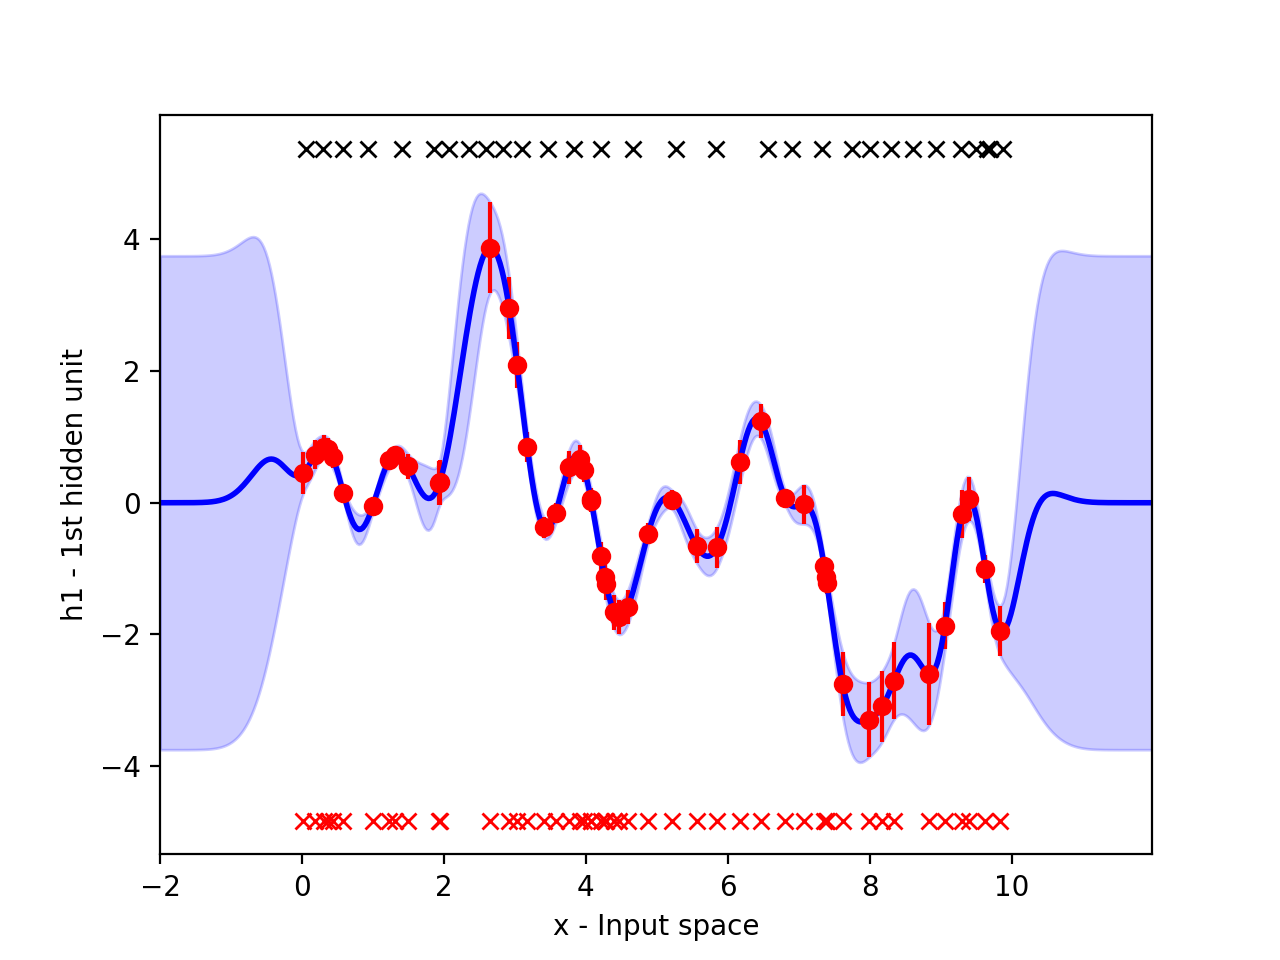

<IPython.core.display.Javascript object>


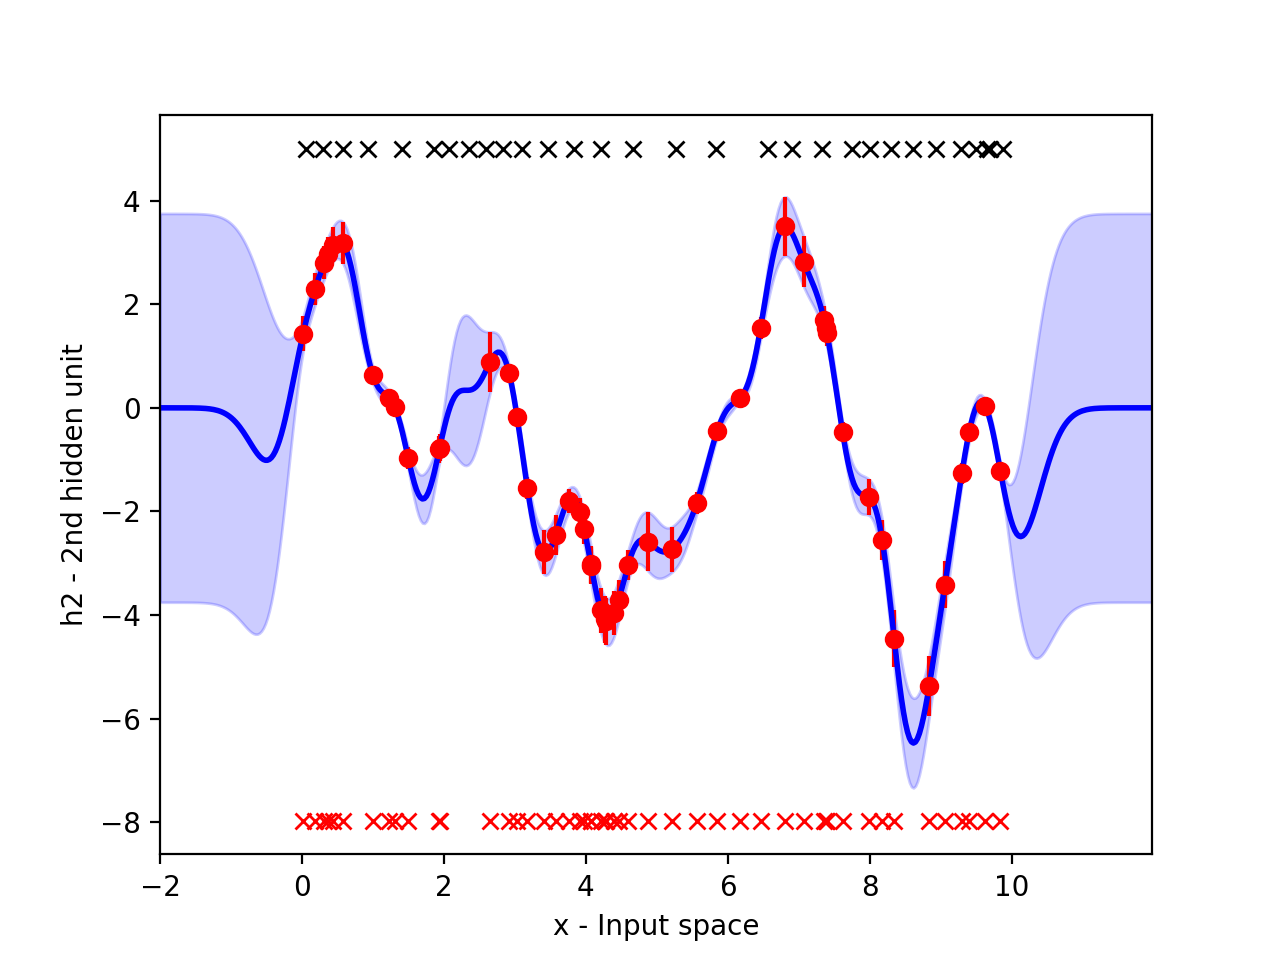

In [211]:
%matplotlib notebook
from plots import DGP_figures
conf_dict = {'M': 30, 'hidden_size': [2], 
            'optimizer':'L-BFGS-B', 'max_it':200,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
def in_h(model, x): 
    m, v = model.sgp_layers[0].forward_prop_thru_post(x)
    return m,v

def h_out(model, m, v): 
    m_out, v_out = model.sgp_layers[1].forward_prop_thru_post(m,v)
    return m_out, v_out
def h_out2(model, z): 
    m_out, v_out = model.sgp_layers[1].forward_prop_thru_post(z)
    return m_out, v_out
def in_out(model, x): 
    m, v = model.predict_f(x)
    return m, v

def plot_in_h(model): 
    for layer in model.sgp_layers:
        layer.update_posterior()
    x_min, x_max = np.min(model.x_train)-2, np.max(model.x_train)+2
    xx = np.linspace(x_min, x_max, 500)[:, None]
    zu = model.sgp_layers[0].zu
    model_init = aep.SDGPR(model.x_train, model.y_train, conf_dict['M'], 
                           conf_dict['hidden_size'], lik='Gaussian')
    model_init.optimise(method='L-BFGS-B', maxiter=0, disp=False)
    zu_init = model_init.sgp_layers[0].zu

    mean, var = in_h(model, xx) #(500,2)2D data
    mean_u, var_u = in_h(model, zu) #2D data

    fig1 = plt.figure()
    plt.plot(xx, mean[:,0], 'b', lw=2)
    plt.fill_between(
        xx[:, 0],
        mean[:, 0] - 2 * np.sqrt(var[:, 0]),
        mean[:, 0] + 2 * np.sqrt(var[:, 0]),
        color='blue', alpha=0.2)
    plt.errorbar(zu, mean_u[:, 0], yerr=2 * np.sqrt(var_u[:, 0]), fmt='ro')

    h1_min,h1_max = np.min(mean[:,0]) - 1.5, np.max(mean[:,0])+1.5
    plt.plot(zu, h1_min * np.ones(zu.shape), 'rx')
    plt.plot(zu_init, h1_max * np.ones(zu_init.shape), 'kx')
    plt.xlim(x_min, x_max)
    plt.xlabel('x - Input space')
    plt.ylabel('h1 - 1st hidden unit')
    
    ## Figure 2
    fig2 = plt.figure()
    plt.plot(xx, mean[:,1], 'b', lw=2)
    plt.fill_between(
        xx[:, 0],
        mean[:, 1] - 2 * np.sqrt(var[:, 1]),
        mean[:, 1] + 2 * np.sqrt(var[:, 1]),
        color='blue', alpha=0.2)
    plt.errorbar(zu, mean_u[:, 1], yerr=2 * np.sqrt(var_u[:, 1]), fmt='ro')

    h1_min,h1_max = np.min(mean[:,1]) - 1.5, np.max(mean[:,1])+1.5
    plt.plot(zu, h1_min * np.ones(zu.shape), 'rx')
    plt.plot(zu_init, h1_max * np.ones(zu_init.shape), 'kx')
    plt.xlim(x_min, x_max)
    plt.xlabel('x - Input space')
    plt.ylabel('h2 - 2nd hidden unit')
    
    return fig1 ,fig2

fig1, fig2 = plot_in_h(model)

<IPython.core.display.Javascript object>


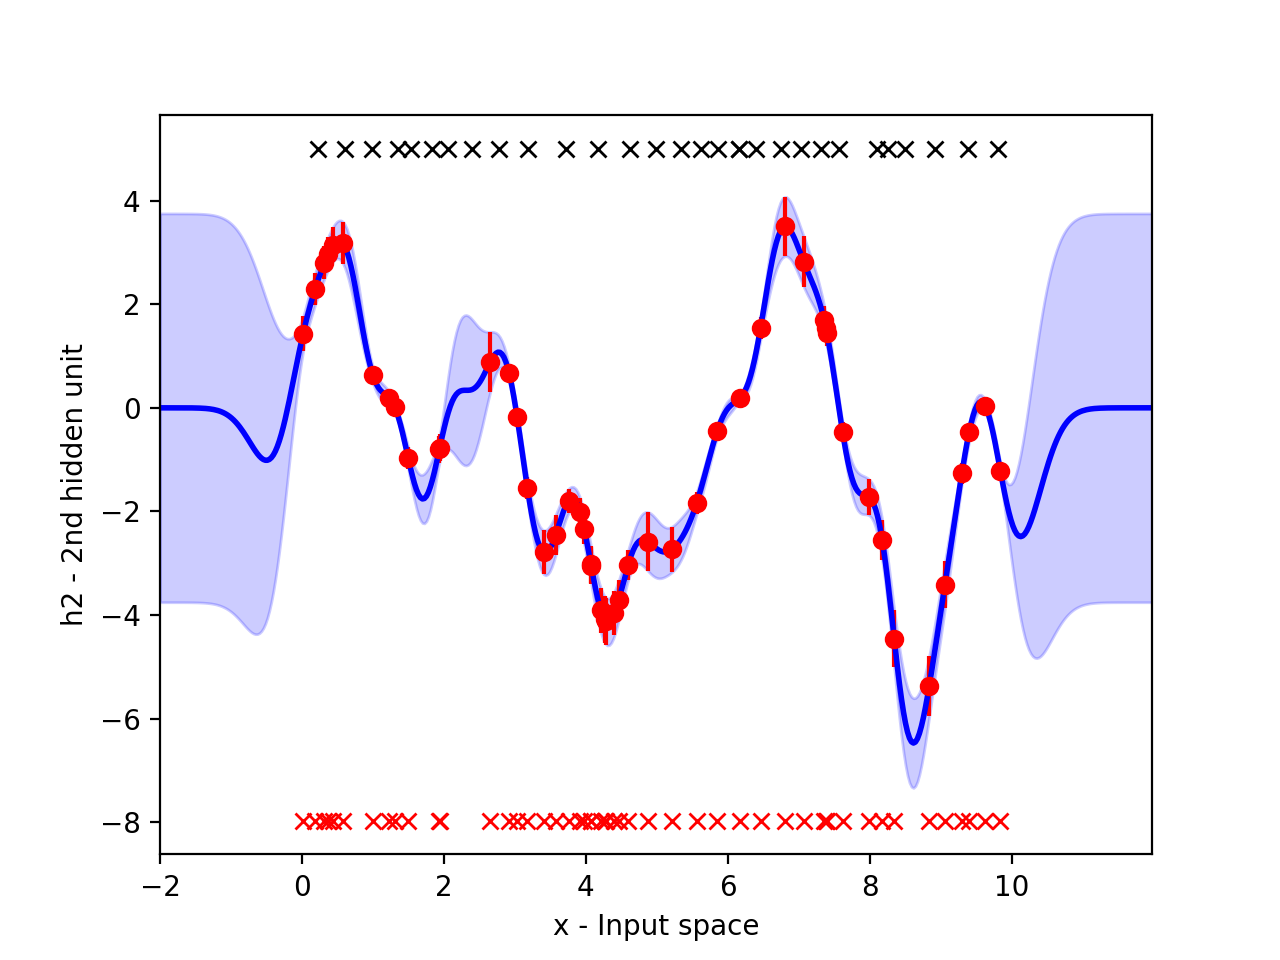

In [176]:
x_min, x_max = np.min(model.x_train)-2, np.max(model.x_train)+2
xx = np.linspace(x_min, x_max, 500)[:, None]
zu = model.sgp_layers[0].zu
model_init = aep.SDGPR(model.x_train, model.y_train, conf_dict['M'], 
                       conf_dict['hidden_size'], lik='Gaussian')
model_init.optimise(method='L-BFGS-B', maxiter=0, disp=False)
zu_init = model_init.sgp_layers[0].zu

mean, var = in_h(model, xx) #(500,2)2D data
mean_u, var_u = in_h(model, zu) #2D data

fig2 = plt.figure()
plt.plot(xx, mean[:,1], 'b', lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 1] - 2 * np.sqrt(var[:, 1]),
    mean[:, 1] + 2 * np.sqrt(var[:, 1]),
    color='blue', alpha=0.2)
plt.errorbar(zu, mean_u[:, 1], yerr=2 * np.sqrt(var_u[:, 1]), fmt='ro')

h1_min,h1_max = np.min(mean[:,1]) - 1.5, np.max(mean[:,1])+1.5
plt.plot(zu, h1_min * np.ones(zu.shape), 'rx')
plt.plot(zu_init, h1_max * np.ones(zu_init.shape), 'kx')
plt.xlim(x_min, x_max)
plt.xlabel('x - Input space')
plt.ylabel('h2 - 2nd hidden unit')

<IPython.core.display.Javascript object>


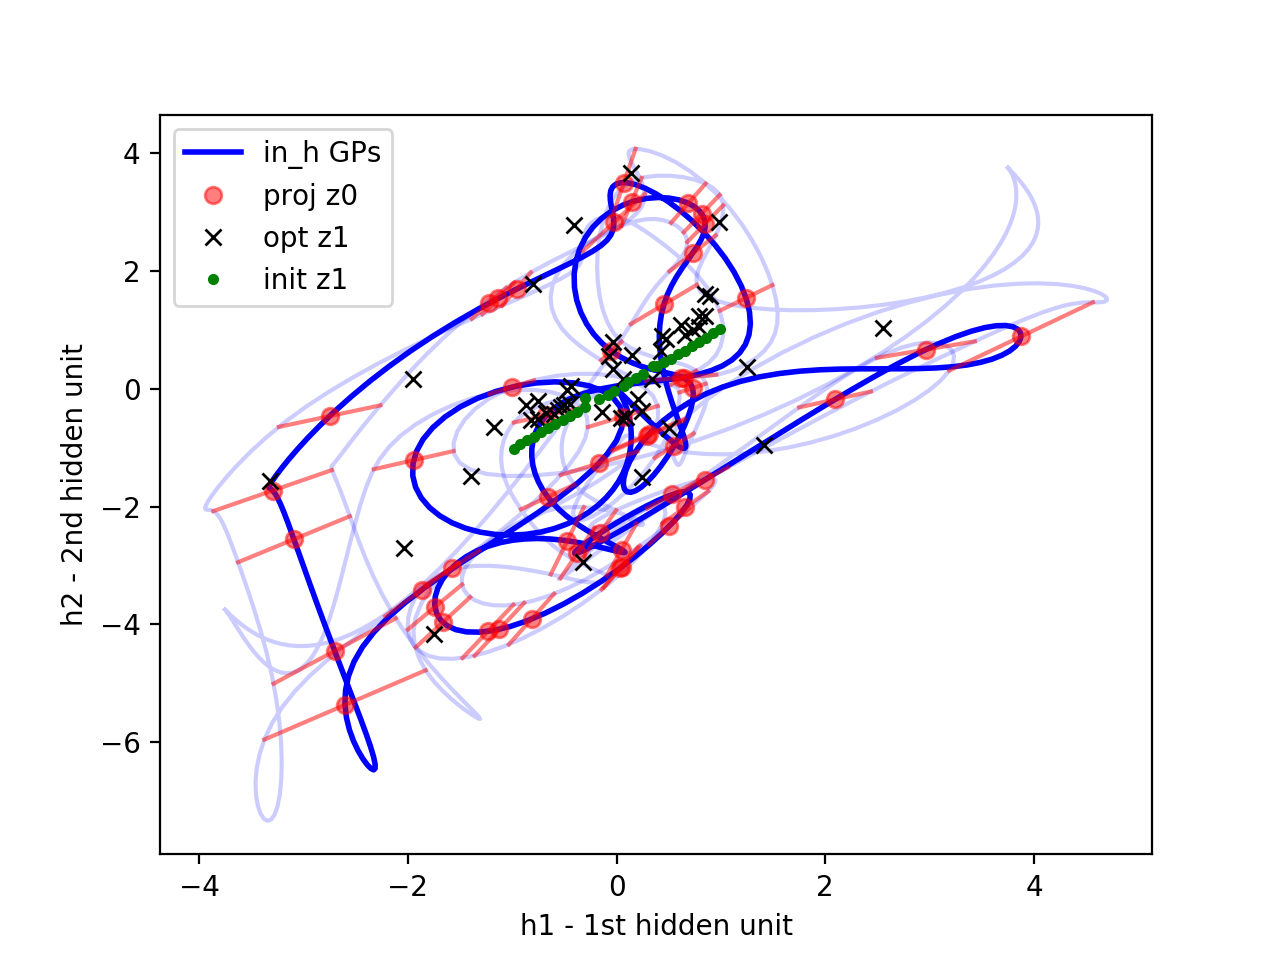

In [222]:
def plot_hidden(model):
    x_min, x_max = np.min(model.x_train)-2, np.max(model.x_train)+2
    xx = np.linspace(x_min, x_max, 500)[:, None]
    zu = model.sgp_layers[0].zu
    z1 = model.sgp_layers[1].zu
    model_init = aep.SDGPR(model.x_train, model.y_train, conf_dict['M'], 
                           conf_dict['hidden_size'], lik='Gaussian')
    model_init.optimise(method='L-BFGS-B', maxiter=0, disp=False)
    zu_init = model_init.sgp_layers[0].zu
    z1_init = model_init.sgp_layers[1].zu

    mean, var = in_h(model, xx) #(500,2)2D data
    mean_u, var_u = in_h(model, zu) #2D data

    fig3 = plt.figure()
    plt.plot( mean[:,0], mean[:,1], 'b', lw=2, label='in_h GPs')
    plt.plot(
        mean[:, 0] - 2 * np.sqrt(var[:, 0]),
        mean[:, 1] - 2 * np.sqrt(var[:, 1]),
        color='blue', alpha=0.2)
    plt.plot(
        mean[:, 0] + 2 * np.sqrt(var[:, 0]),
        mean[:, 1] + 2 * np.sqrt(var[:, 1]),
        color='blue', alpha=0.2)
    plt.plot(mean_u[:, 0], mean_u[:, 1], 'ro',alpha=0.5,label='proj z0')
    for i in range(zu.shape[0]):
        plt.plot([mean_u[i, 0] - 2 * np.sqrt(var_u[i, 0]),mean_u[i, 0] + 2 * np.sqrt(var_u[i, 0])],
                 [mean_u[i, 1] - 2 * np.sqrt(var_u[i, 1]),mean_u[i, 1] + 2 * np.sqrt(var_u[i, 1])],
                'r', alpha=0.5)

    plt.plot(z1[:, 0], z1[:, 1], 'xk', label='opt z1')
    plt.plot(z1_init[:, 0], z1_init[:, 1], 'g.', label='init z1')
    plt.ylabel('h2 - 2nd hidden unit')
    plt.xlabel('h1 - 1st hidden unit')
    plt.legend()
    return fig3

fig3 = plot_hidden(model)

<IPython.core.display.Javascript object>


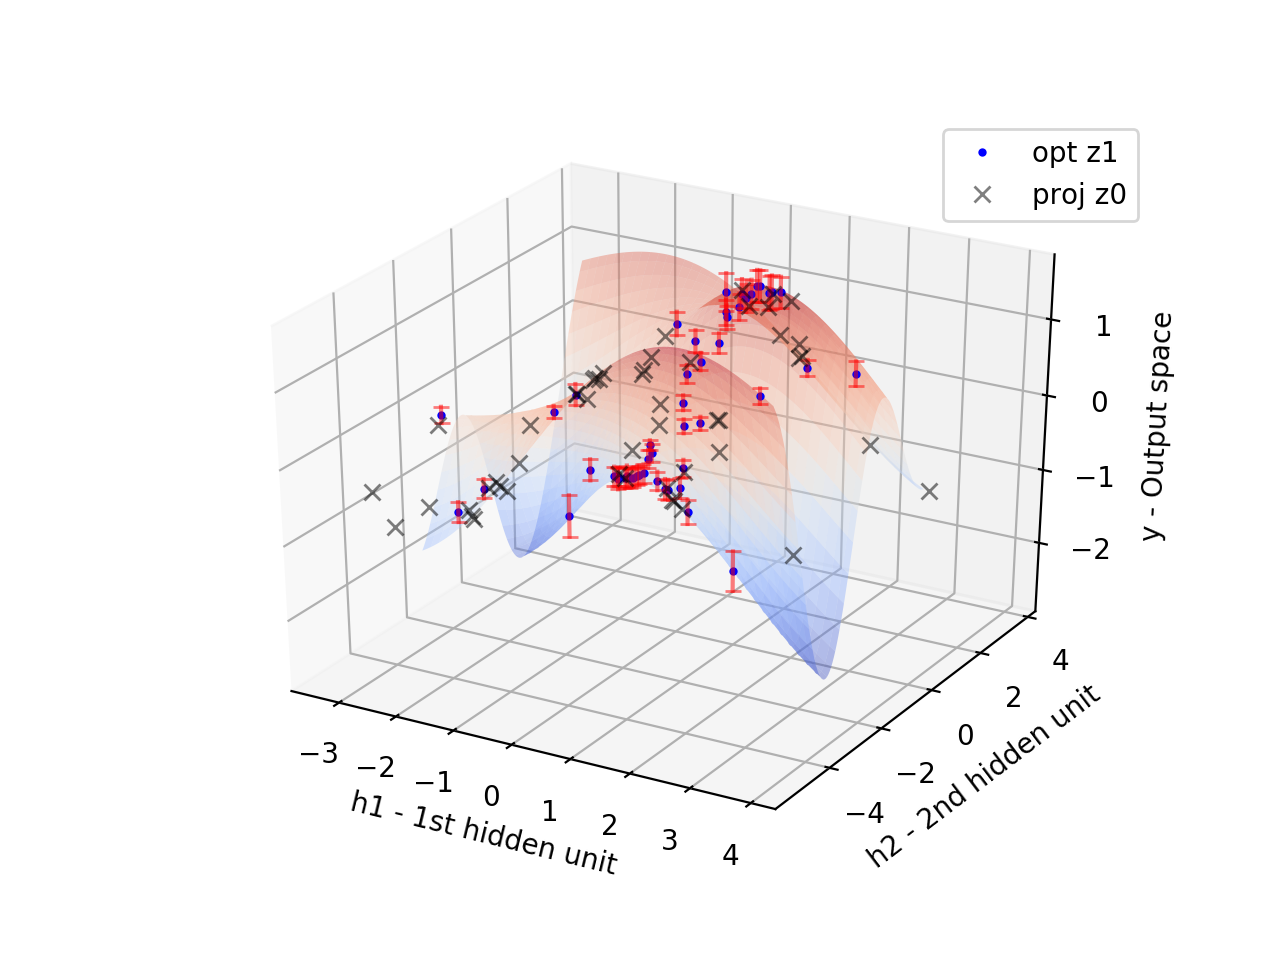

<IPython.core.display.Javascript object>


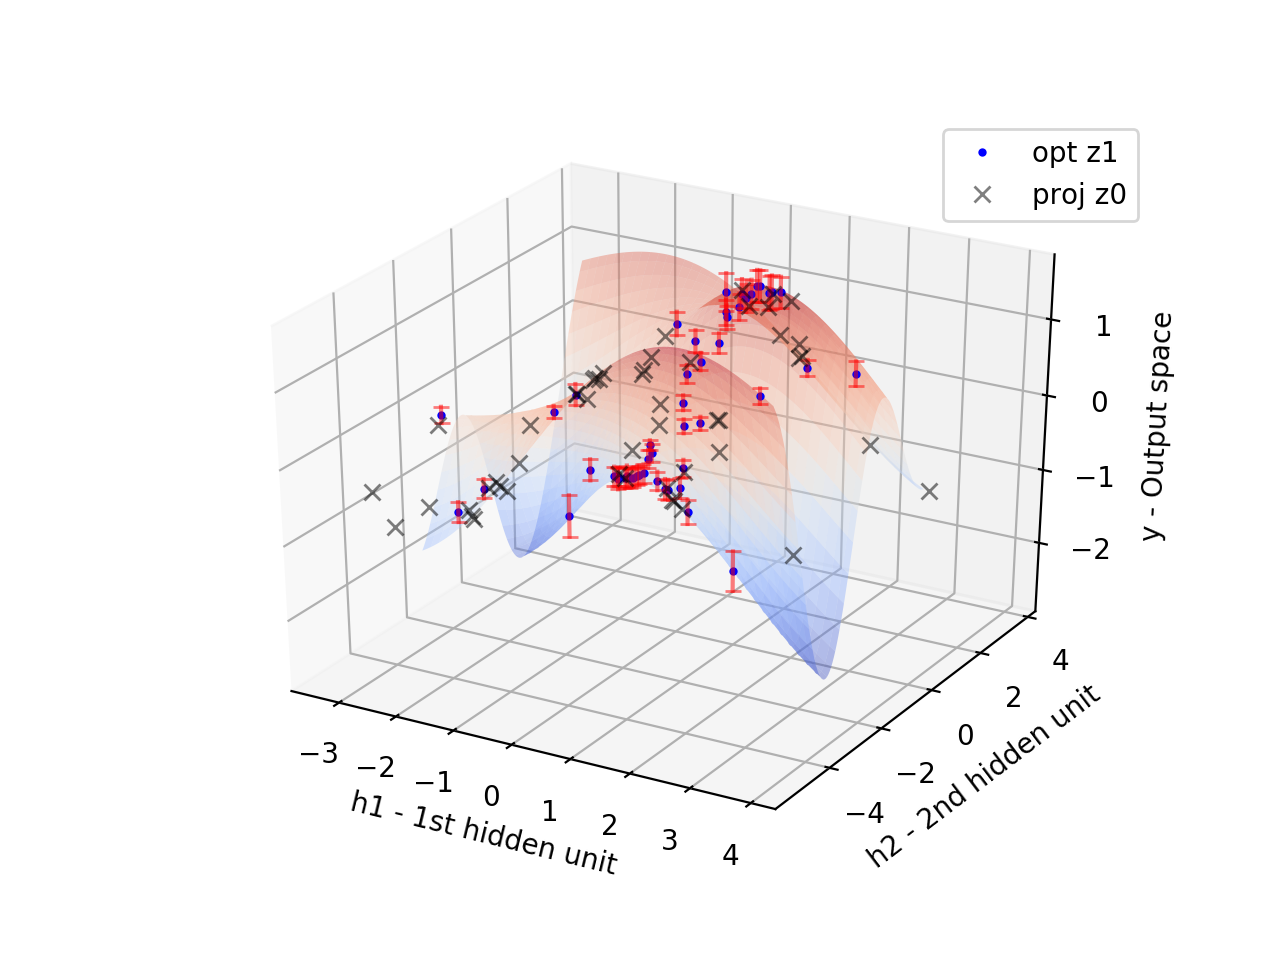

In [227]:
from matplotlib import cm
def plot_h_out(model): 
    x_min, x_max = np.min(model.x_train)-2, np.max(model.x_train)+2
    xx = np.linspace(x_min, x_max, 500)[:, None]
    zu = model.sgp_layers[0].zu
    z1 = model.sgp_layers[1].zu
    model_init = aep.SDGPR(model.x_train, model.y_train, conf_dict['M'], 
                           conf_dict['hidden_size'], lik='Gaussian')
    model_init.optimise(method='L-BFGS-B', maxiter=0, disp=False)
    zu_init = model_init.sgp_layers[0].zu
    z1_init = model_init.sgp_layers[1].zu

    mean, var = in_h(model, xx) #(500,2)2D data
    mean_u, var_u = in_h(model, zu) #2D data

    mean_u_out, var_u_out = in_out(model, zu) 
    mz1, vz1 = h_out2(model, z1)

    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax = fig.gca(projection='3d')
    x = y = np.arange(-5.0, 5.0, 0.25)
    H1, H2 = np.meshgrid(x, y)
    zs = np.array([h_out2(model, np.array([x,y]))[0]for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    ax1.plot_surface(X, Y, Z, alpha=0.4,cmap=cm.coolwarm)
    ax.plot(z1[:,0],z1[:,1],mz1[:,0],'.b', mew=0, label='opt z1')
    for i in range(mz1.shape[0]):
        ax.plot([z1[i,0],z1[i,0]], [z1[i,1],z1[i,1]]
            ,[mz1[i,0] - zu1_err[i,0], mz1[i,0] + zu1_err[i,0]] ,marker='_', color='r',alpha=0.5)

    ax.plot(mean_u[:,0],mean_u[:,1],mean_u_out[:,0],'kx',alpha=0.5, label='proj z0' ) 
    ax1.set_xlabel('h1 - 1st hidden unit')
    ax1.set_ylabel('h2 - 2nd hidden unit')
    ax1.set_zlabel('y - Output space')
    ax.legend()
    return fig
plot_h_out(model)

<IPython.core.display.Javascript object>


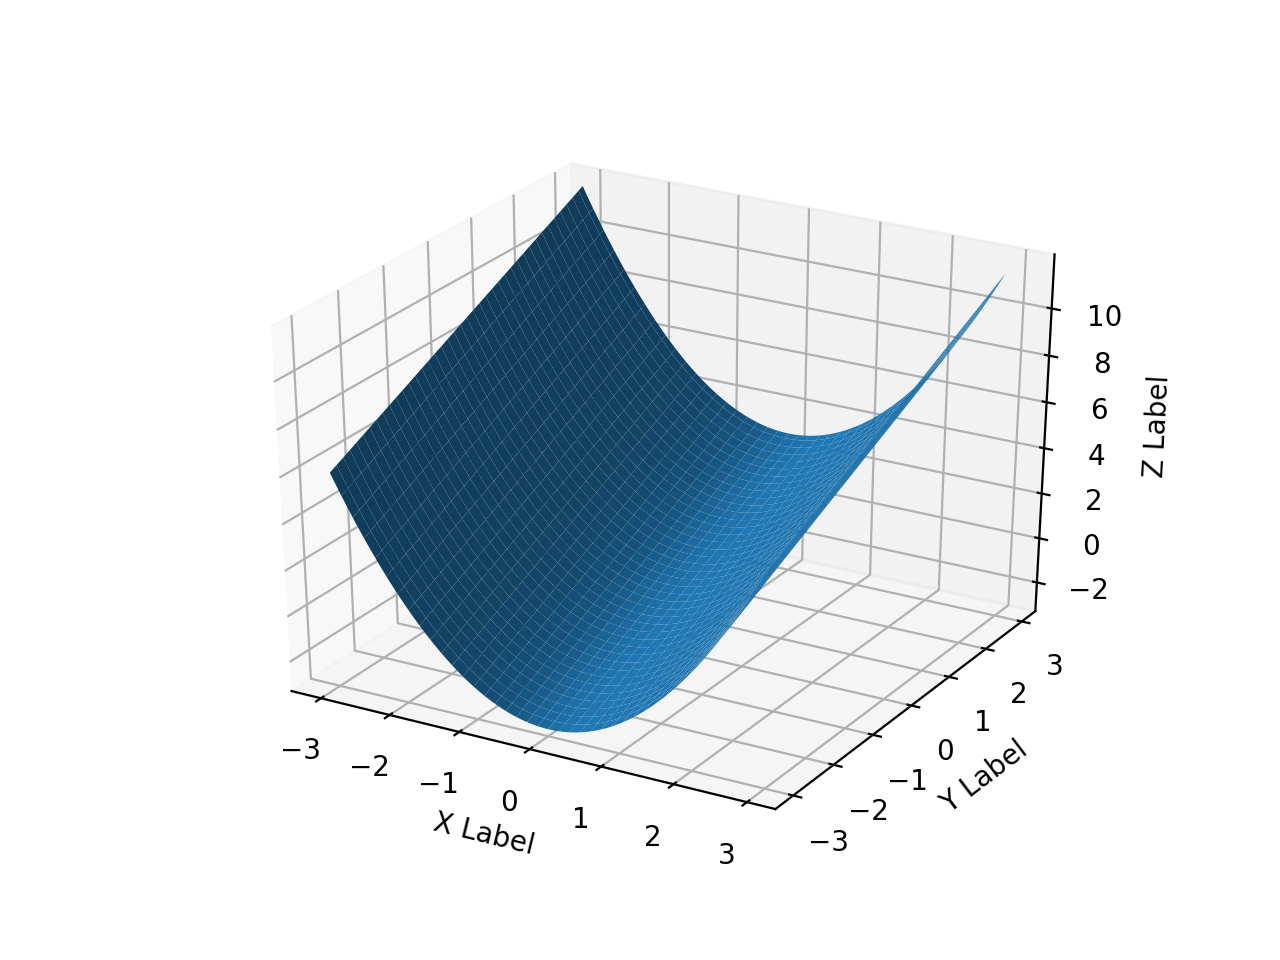

[[-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]
 ..., 
 [-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...,  2.85  2.9   2.95]]


In [171]:
def fun(x, y):
    return x**2 + y
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax1.plot_surface(X, Y, Z)

ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')



plt.show()
print X


<IPython.core.display.Javascript object>


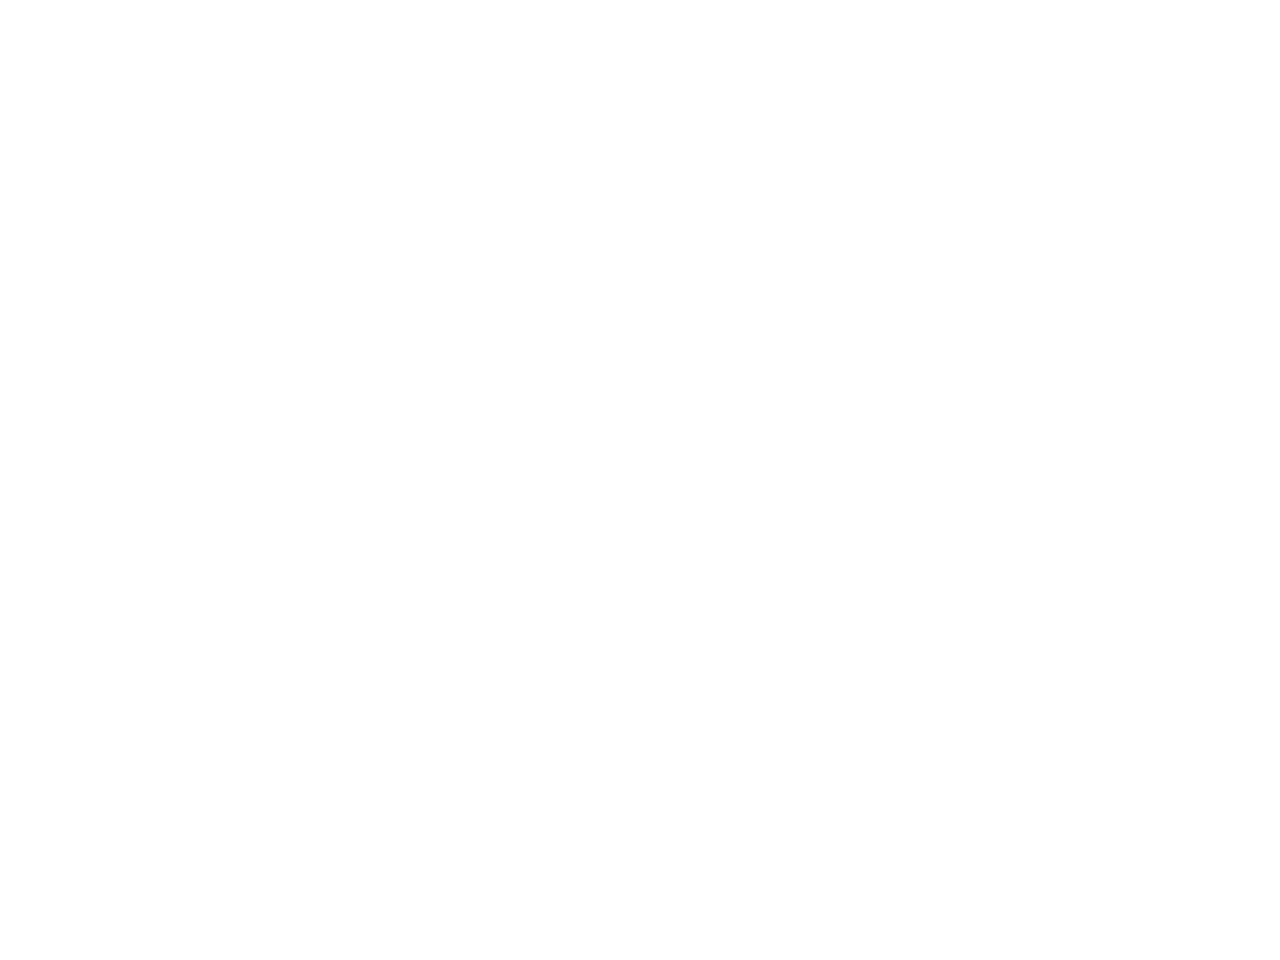

<IPython.core.display.Javascript object>


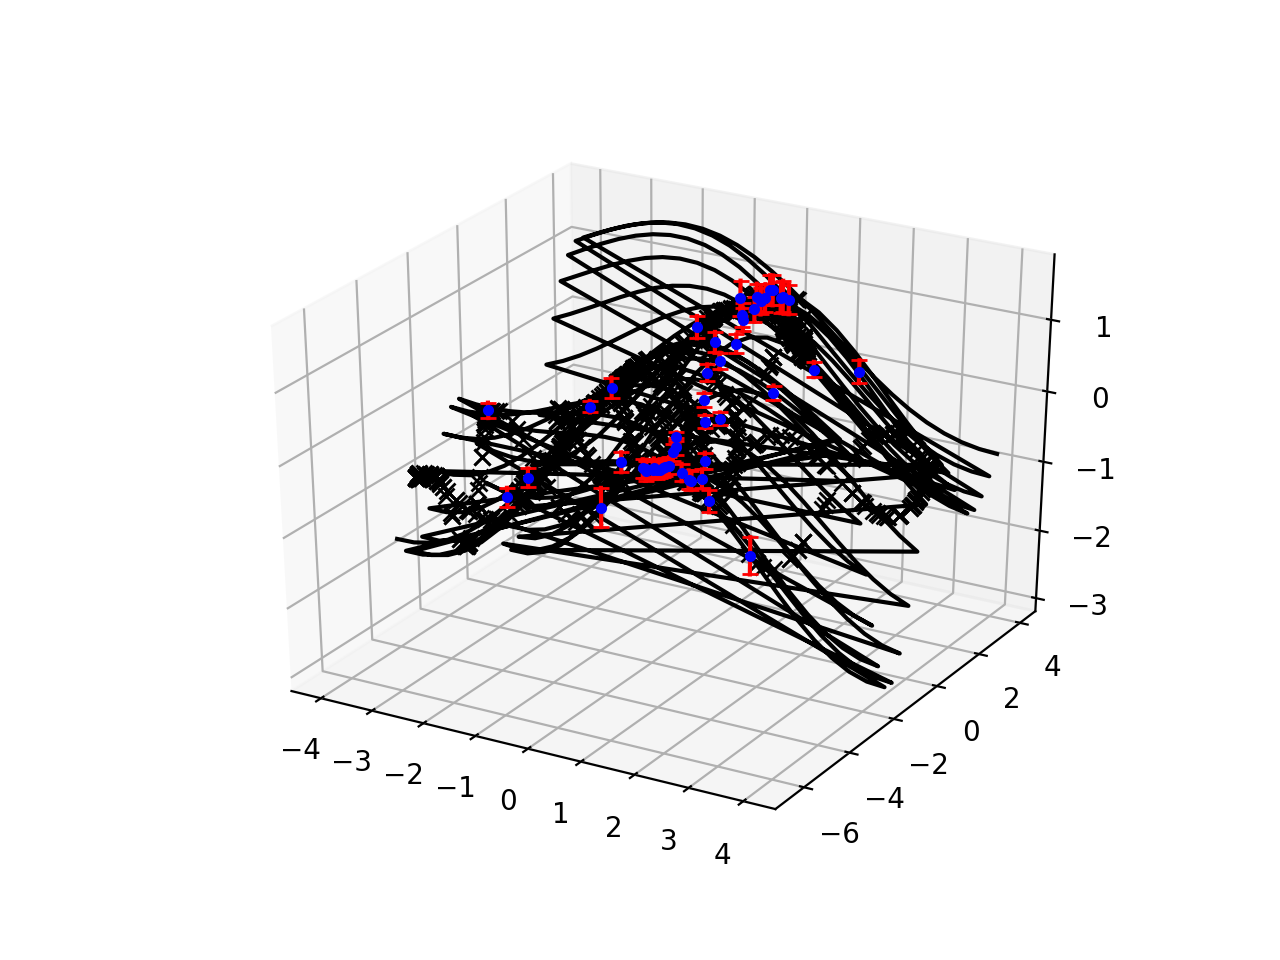

In [167]:











mz0, vz0 = model.sgp_layers[0].forward_prop_thru_post(z0)    

## In output space:

m_z0_out, v_z0_out = model.predict_f(z0)
# miz1, viz1 = model.sgp_layers[1].forward_prop_thru_post(mz0, vz0)
# projection of first hidden-layers pseudo
mz1, vz1 = model.sgp_layers[1].forward_prop_thru_post(z1)



#This relate to training pts
mout, vout = model.sgp_layers[0].forward_prop_thru_post(model.x_train)
mi, vi = model.sgp_layers[1].forward_prop_thru_post(mout,vout)


x_min, x_max = np.min(model.x_train), np.max(model.x_train)
xx = np.linspace(x_min, x_max, 500)[:, None]
m_0, v_0 = model.sgp_layers[0].forward_prop_thru_post(xx)
# #Hidden space for pseudoinput projections and hidden layer inputs
fig3= plt.figure()
plt.plot(z1[:,0],z1[:,1], 'bx' )
plt.plot(mz0[:,0],mz0[:,1], 'r.' )
plt.plot(m_0[:,0],m_0[:,1] )
plt.title('projectios of inputs and z0 in hidden space and z1')
plt.show()


# plt.figure()
# plt.plot(model.x_train, mi,'.b')
# plt.plot(z0, miz1, '+r')
# plt.show()

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
fig = plt.figure()
ax = fig.gca(projection='3d')

h1 = np.linspace(-4,4, 25)[:, None]
h2 = np.linspace(-4,4, 25)[:, None]
hx,hy = np.meshgrid(h1,h2)
hx,hy = hx.reshape(-1,1),hy.reshape(-1,1)
h = np.concatenate((hx,hy), axis=1)
m_h, v_h = model.sgp_layers[1].forward_prop_thru_post(h)
# print m_h
ax.plot(h[:,0],h[:,1],m_h[:,0],'k-')

mout, vout = model.sgp_layers[0].forward_prop_thru_post(model.x_train)
mi, vi = model.sgp_layers[1].forward_prop_thru_post(mout,vout)

zu1_err = 2*np.sqrt(vz1)

ax.plot(mout[:,0],mout[:,1],mi[:,0],'xk')
for i in range(mz1.shape[0]):
    ax.plot([z1[i,0],z1[i,0]], [z1[i,1],z1[i,1]]
        ,[mz1[i,0] - zu1_err[i,0], mz1[i,0] + zu1_err[i,0]] ,marker='_', color='r')

# ax.plot(z1[:,0],z1[:,1],mz1[:,0]+ 2*np.sqrt(vz1[:,0]),'.b')
# ax.plot(z1[:,0],z1[:,1],mz1[:,0]- 2*np.sqrt(vz1[:,0]),'.b')
ax.plot(z1[:,0],z1[:,1],mz1[:,0],'.b')

# ax.errorbar(z1[:,0],z1[:,1],mz1[:,0], yerr=2 * np.sqrt(vz1[:,0]), fmt='ro')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
plt.show()




In [162]:
model_init = aep.SDGPR(model.x_train, model.y_train, conf_dict['M'], 
                       conf_dict['hidden_size'], lik='Gaussian')
params = model_init.optimise(method='L-BFGS-B', maxiter=10, disp=False)
model_init.objective_function(params, mb_size=N_train)[1]['zu_1']

array([[  8.72816142e-03,   2.45196272e-02],
       [  7.76888759e-03,   1.44562364e-03],
       [ -1.11117227e-02,  -3.70714125e-03],
       [  1.79995402e-03,  -5.42320194e-03],
       [ -1.67074157e-02,   5.43300904e-03],
       [  2.80614006e-02,  -2.91491471e-03],
       [  1.79468468e-01,  -6.73521730e-02],
       [  6.52256739e-02,  -1.13478670e-03],
       [  8.68306736e-04,  -2.38938734e-02],
       [ -8.09139026e-04,  -4.92162384e-03],
       [  1.14017655e-03,  -1.47585372e-02],
       [  7.60444507e-01,   2.02792842e-01],
       [ -1.49577547e-02,   1.95036160e-04],
       [ -1.69223169e-02,   2.00218327e-02],
       [ -1.38393628e-01,  -1.56245735e-01],
       [ -2.33569434e-01,  -5.18084428e-02],
       [ -2.07720842e-01,  -6.33939706e-02],
       [ -2.49388024e-03,  -3.96155800e-03],
       [ -3.23621781e-02,   3.98871747e-03],
       [  1.86279288e-01,  -6.44689416e-03],
       [ -9.30273691e-02,   1.84917900e-02],
       [  1.08686241e-02,  -7.29647494e-03],
       [  

<IPython.core.display.Javascript object>


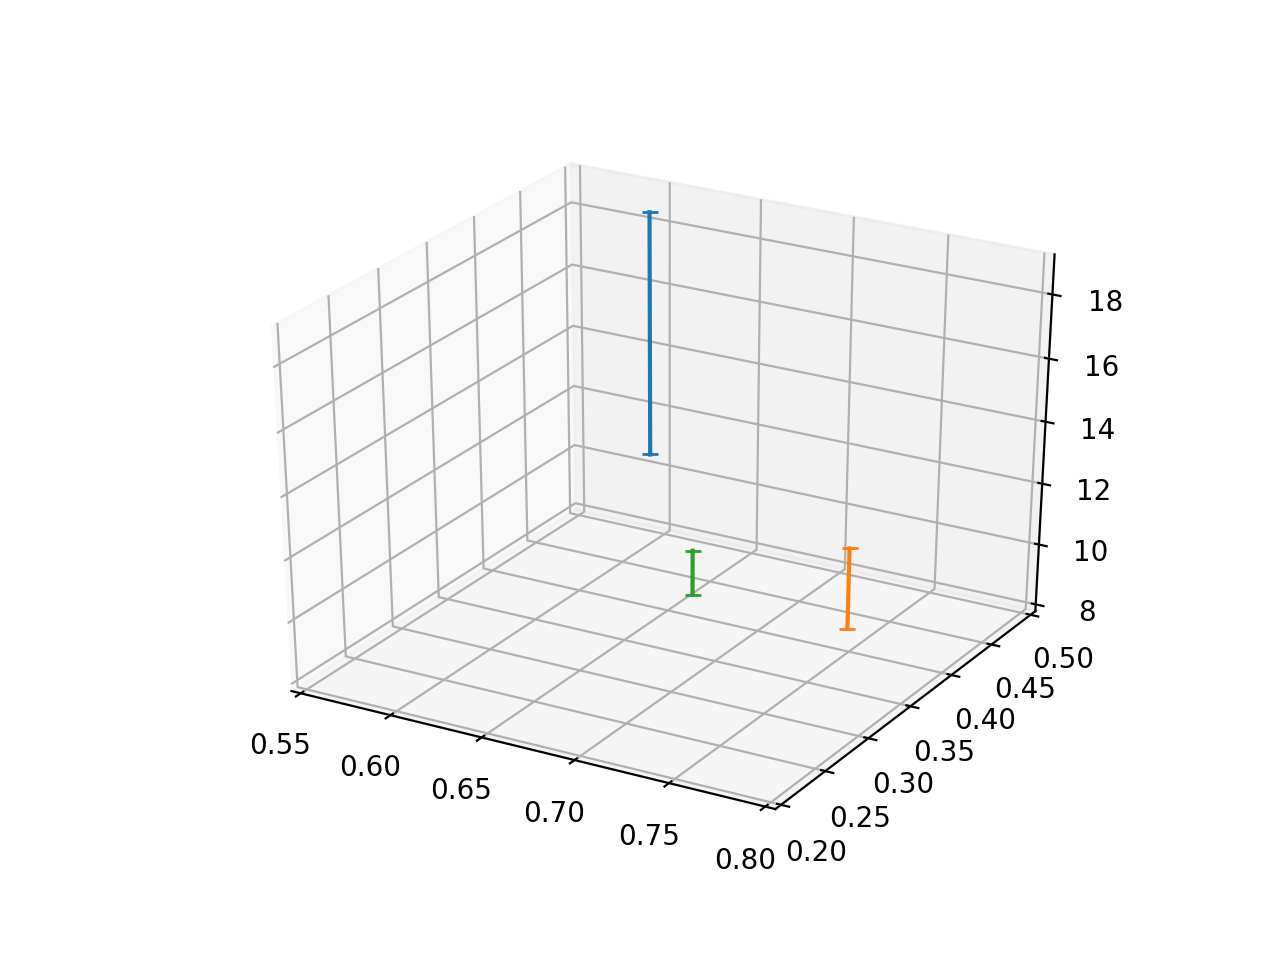

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')



#data
fx = [0.673574075,0.727952994,0.6746285]
fy = [0.331657721,0.447817839,0.37733386]
fz = [18.13629648,8.620699842,9.807536512]

#error data
xerror = [0.041504064,0.02402152,0.059383144]
yerror = [0.015649804,0.12643117,0.068676131]
zerror = [3.677693713,1.345712547,0.724095592]

#plot points
#ax.plot(fx, fy, fz, linestyle="None", marker="o")

#plot errorbars
for i in np.arange(0, len(fx)):
    #ax.plot([fx[i]+xerror[i], fx[i]-xerror[i]], [fy[i], fy[i]], [fz[i], fz[i]], marker="_")
    #ax.plot([fx[i], fx[i]], [fy[i]+yerror[i], fy[i]-yerror[i]], [fz[i], fz[i]], marker="_")
    ax.plot([fx[i], fx[i]], [fy[i], fy[i]], [fz[i]+zerror[i], fz[i]-zerror[i]], marker="_")

#configure axes
ax.set_xlim3d(0.55, 0.8)
ax.set_ylim3d(0.2, 0.5)
ax.set_zlim3d(8, 19)

plt.show()

<IPython.core.display.Javascript object>


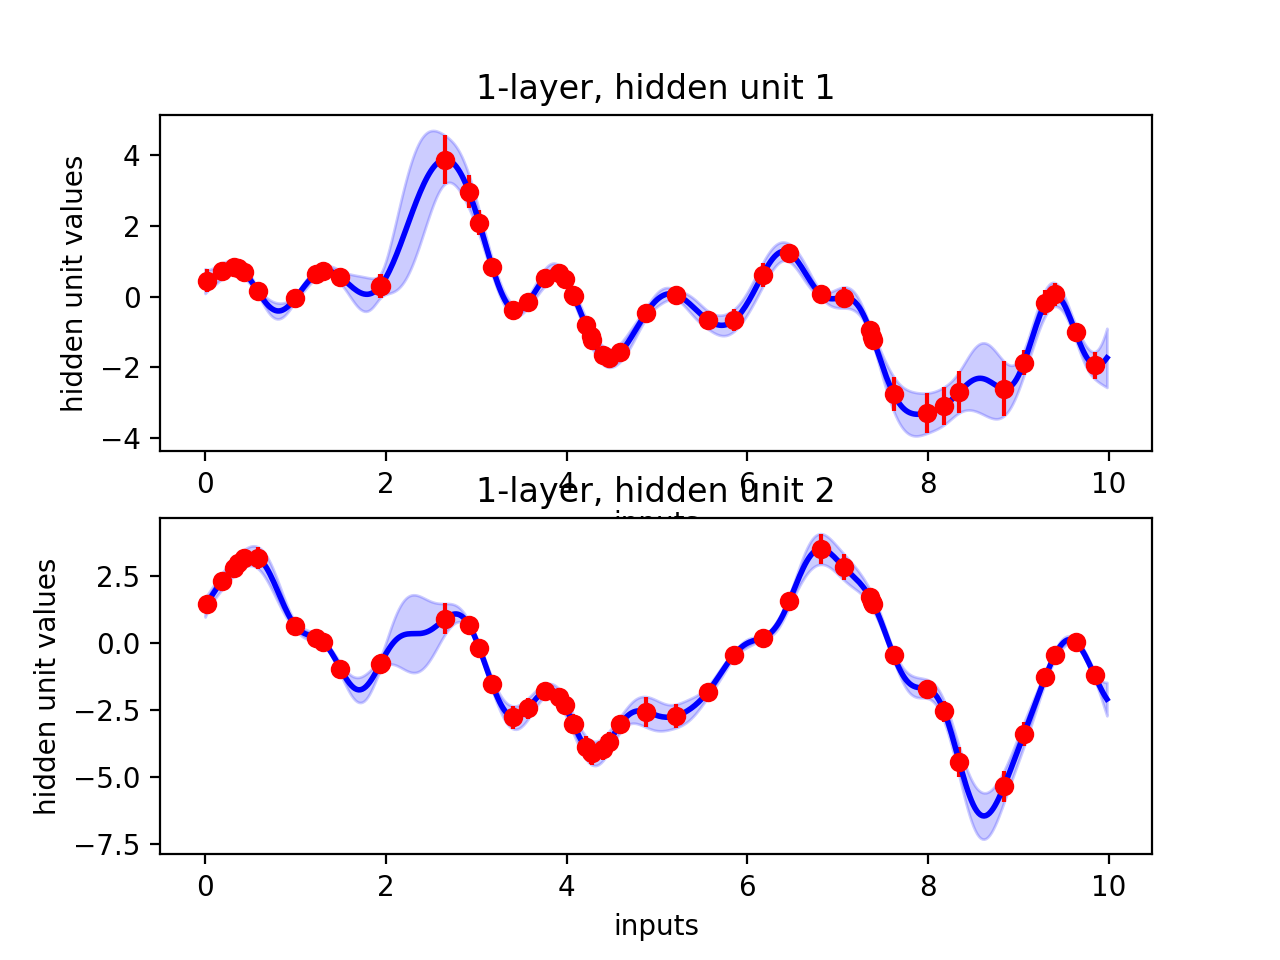

(500, 1) (500, 1)


<IPython.core.display.Javascript object>


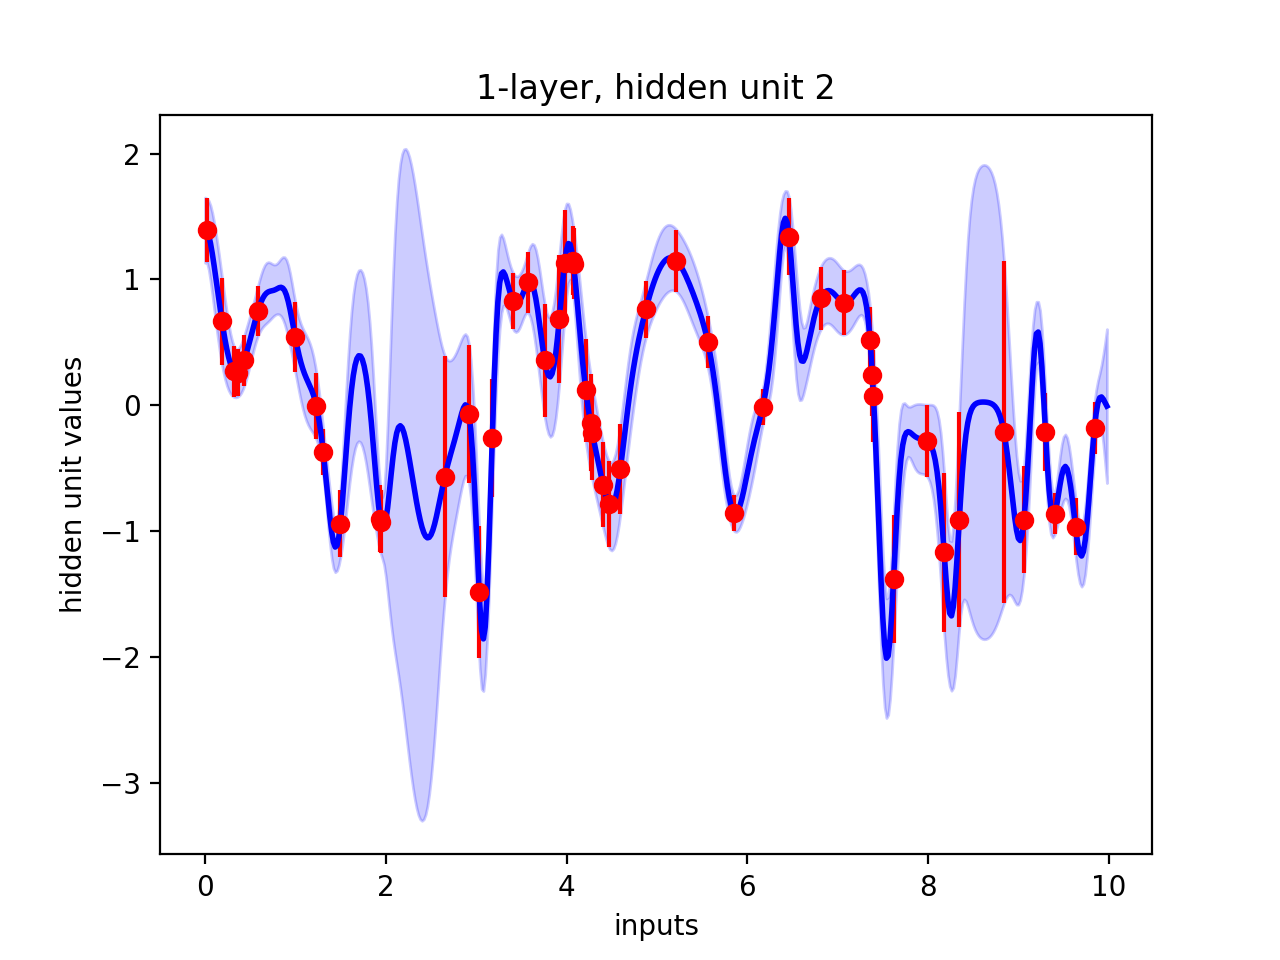

In [36]:
# zu_0 = model.sgp_layers[0].zu
# zu_1 = model.sgp_layers[1].zu
# for layer in model.sgp_layers:
#     layer.update_posterior()
    
# zu_0 = model.sgp_layers[0].zu
x_min, x_max = np.min(model.x_train), np.max(model.x_train)
xx = np.linspace(x_min, x_max, 500)[:, None]
m_0, v_0 = model.sgp_layers[0].forward_prop_thru_post(xx)
mtr_0, vtr_0 = model.sgp_layers[0].forward_prop_thru_post(model.x_train)
mzu_0, vzu_0 = model.sgp_layers[0].forward_prop_thru_post(zu_0)


# m_out, v_out = model.predict_f(xx)
# mtr_out, vtr_out = model.sgp_layers[1].forward_prop_thru_post(mtr_0,vtr_0)
# mzu_out, vzu_out = model.predict_f(zu_0)

# mizu_1, vizu_1 = model.sgp_layers[1].forward_prop_thru_post(mzu_0, vzu_0)
# mzu_1, vzu_1 = model.sgp_layers[1].forward_prop_thru_post(zu_1)




fig1 = plt.figure()
plt.subplot(2, 1, 1)
# plt.plot(model.x_train, mtr_0[:,0], 'kx', mew=2)
plt.plot(xx, m_0[:,0], 'b', lw=2)
plt.fill_between(
    xx[:, 0],
    m_0[:, 0] - 2 * np.sqrt(v_0[:, 0]),
    m_0[:, 0] + 2 * np.sqrt(v_0[:, 0]),
    color='blue', alpha=0.2)
plt.errorbar(zu_0, mzu_0[:, 0], yerr=2 * np.sqrt(vzu_0[:,0]), fmt='ro')
plt.xlabel('inputs')
plt.ylabel('hidden unit values')
plt.title('1-layer, hidden unit 1')

plt.subplot(2, 1, 2)
#plt.plot(model.x_train, mtr_0[:,1], 'kx', mew=2)
plt.plot(xx, m_0[:,1], 'b', lw=2)
plt.fill_between(
    xx[:, 0],
    m_0[:, 1] - 2 * np.sqrt(v_0[:, 1]),
    m_0[:, 1] + 2 * np.sqrt(v_0[:, 1]),
    color='blue', alpha=0.2)
plt.errorbar(zu_0, mzu_0[:, 1], yerr=2 * np.sqrt(vzu_0[:,1]), fmt='ro')
plt.xlabel('inputs')
plt.ylabel('hidden unit values')
plt.title('1-layer, hidden unit 2')


# From input to output spaces
xx = np.linspace(x_min, x_max, 500)[:, None]
m_out, v_out = model.predict_f(xx)
m_zu_0_out, v_zu_0_out = model.predict_f(zu_0)
print m_out.shape, xx.shape
fig2 = plt.figure()
plt.plot(xx, m_out, 'b', lw=2)
plt.fill_between(
    xx[:, 0],
   m_out[:, 0] - 2 * np.sqrt(v_out[:, 0]),
   m_out[:, 0] + 2 * np.sqrt(v_out[:, 0]),color='blue', alpha=0.2)
plt.errorbar(zu_0, m_zu_0_out, yerr=2 * np.sqrt(v_zu_0_out), fmt='ro')
plt.xlabel('inputs')
plt.ylabel('hidden unit values')
plt.title('1-layer, hidden unit 2')


# fig3 = plt.figure()
# plt.plot(model.x_train, mtr_out, 'kx', mew=2)
# plt.plot(xx, m_out, 'b', lw=2)
# plt.fill_between(
#     xx[:, 0],
#     m_out.reshape(-1,) - 2 * np.sqrt(v_out.reshape(-1,)),
#     m_out.reshape(-1,) + 2 * np.sqrt(v_out.reshape(-1,)),
#     color='blue', alpha=0.2)
# plt.errorbar(zu_0, mzu_out.reshape(-1,), yerr=2 * np.sqrt(vzu_out.reshape(-1,)), fmt='ro')
# plt.xlabel('inputs x')
# plt.ylabel('output y')
# plt.title('from input to output')
# plt.show()

<IPython.core.display.Javascript object>


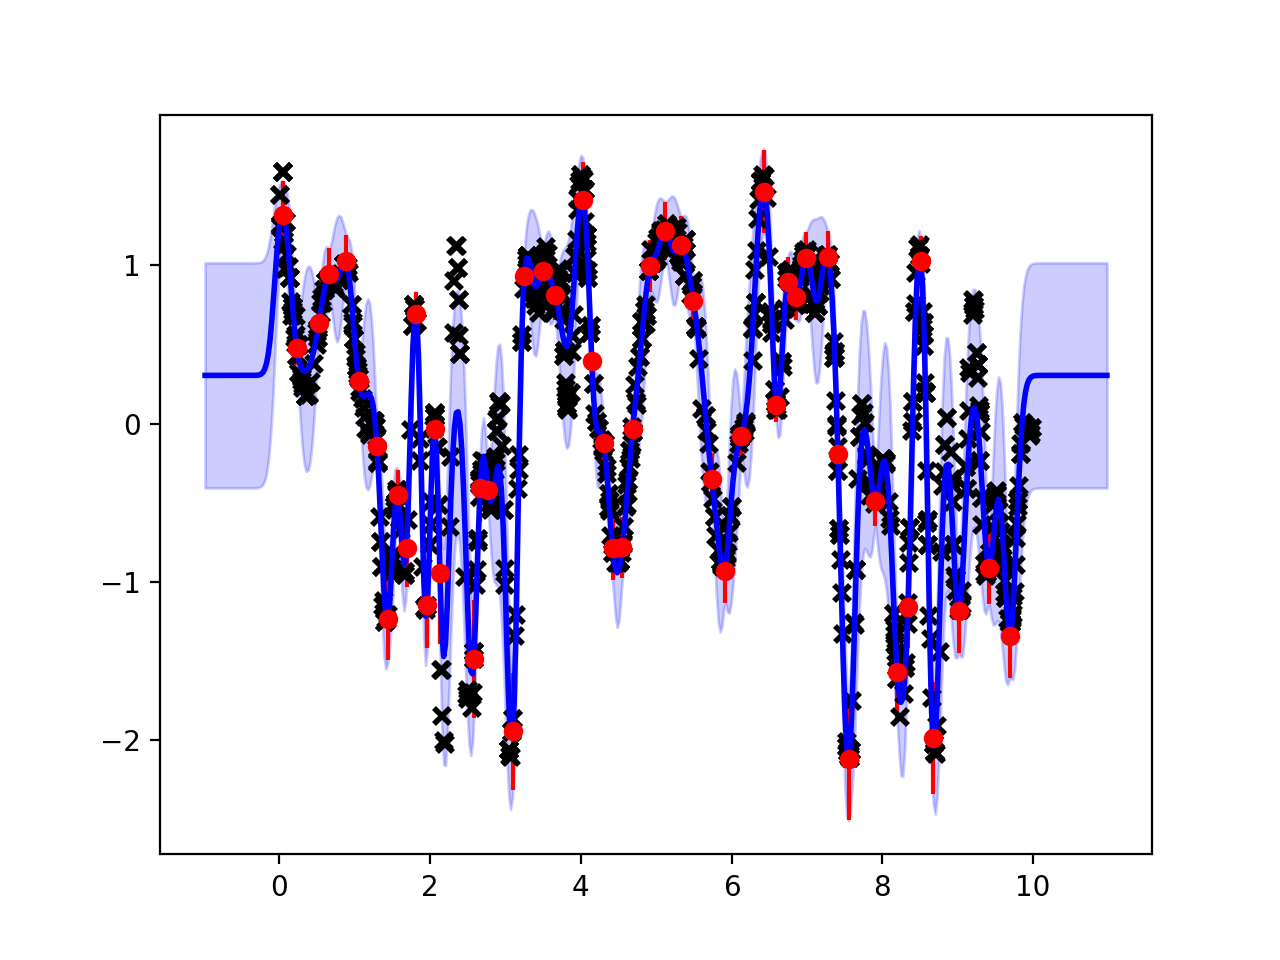

In [13]:
m = model

x_min, x_max = np.min(m.x_train)-1, np.max(m.x_train)+1
xx = np.linspace(x_min, x_max, 500)[:, None]
mean, var = m.predict_f(xx)
zu = m.sgp_layers[0].zu
mean_u, var_u = m.predict_f(zu)
fig = plt.figure()
plt.plot(m.x_train, m.y_train, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color='blue', alpha=0.2)
plt.errorbar(zu, mean_u, yerr=2 * np.sqrt(var_u), fmt='ro')
plt.show()

In [14]:
baseline = pd.DataFrame()
with open('baseline_list') as baseline_list: 
    for baseline_name in baseline_list:
        baseline_new = pd.read_csv(baseline_name.strip(), header=0, index_col=0)
        baseline = pd.concat((baseline,baseline_new), axis=0)
baseline_GP = baseline[baseline.model == 'GP']
baseline_SGP = baseline[baseline.model== 'SGP']
baseline_DGP = baseline[baseline['model'] == 'DGP']

default = pd.DataFrame()
with open('default_list') as default_list: 
    for default_name in default_list:
        default_new = pd.read_csv(default_name.strip(), header=0, index_col=0)
        default = pd.concat((default,default_new), axis=0)


short_long = pd.DataFrame()
with open('short_long_list') as short_long_list: 
    for short_long_name in short_long_list:
        short_long_new = pd.read_csv(short_long_name.strip(), header=0, index_col=0)
        short_long = pd.concat((short_long,short_long_new), axis=0)


long_short = pd.DataFrame()
with open('long_short_list') as long_short_list: 
    for long_short_name in long_short_list:
        long_short_new = pd.read_csv(long_short_name.strip(), header=0, index_col=0)
        long_short = pd.concat((long_short,long_short_new), axis=0)

baseline_SGP = baseline[baseline['model'] == 'SGP']

baseline_SGP_30 = baseline_SGP[baseline_SGP['M'] == 30]
baseline_SGP_40 = baseline_SGP[baseline_SGP['M'] == 40]
baseline_SGP_50 = baseline_SGP[baseline_SGP['M'] == 50]

default_30 = default[default['M'] == 30]
default_40 = default[default['M'] == 40]
default_50 = default[default['M'] == 50]

short_long_30 = short_long[short_long['M'] == 30]
short_long_40 = short_long[short_long['M'] == 40]
short_long_50 = short_long[short_long['M'] == 50]

long_short_30 = long_short[long_short['M'] == 30]
long_short_40 = long_short[long_short['M'] == 40]
long_short_50 = long_short[long_short['M'] == 50]

In [18]:
baseline_SGP_50

,exp,model,N_train,M,hidden_size,optimizer,mse,nll,config,init,outlier,time
0,exp_3,SGP,75,50.0,NaN,NaN,0.364284,0.712632,NaN,long_short,NaN,4.182077
0,exp_4,SGP,75,50.0,NaN,NaN,0.397822,0.628185,NaN,long_short,NaN,6.838493
0,exp_3,SGP,100,50.0,NaN,NaN,0.264033,0.686880,NaN,long_short,NaN,4.014797
0,exp_3,SGP,250,50.0,NaN,NaN,0.165665,0.434407,NaN,long_short,NaN,6.197317
0,exp_3,SGP,500,50.0,NaN,NaN,0.043806,-0.054509,NaN,long_short,NaN,5.461981
0,exp_4,SGP,100,50.0,NaN,NaN,0.326793,0.705905,NaN,long_short,NaN,3.698401
0,exp_4,SGP,250,50.0,NaN,NaN,0.154441,0.375598,NaN,long_short,NaN,8.027964
0,exp_3,SGP,750,50.0,NaN,NaN,0.031683,-0.278690,NaN,long_short,NaN,5.468406
0,exp_4,SGP,500,50.0,NaN,NaN,0.079713,0.300302,NaN,long_short,NaN,5.975527
0,exp_3,SGP,1000,50.0,NaN,NaN,0.011568,-0.420148,NaN,long_short,NaN,8.066165


In [16]:
mean_aep, var_aep = model.predict_y(X_test.reshape([X_test.shape[0], 1]))
results_aep = metrics.METRICS(y_test, mean_aep, var_aep)
mse_aep , nll_aep = results_aep.mse(), results_aep.nll()
print 'test mse=%.3f, nll=%.3f' % (mse_aep, nll_aep)

test mse=0.034, nll=-0.345
